In [1]:
from tectosaur2.nb_config import setup
setup()

## Setup geometry

In [2]:
import cutde.fullspace as FS
import cutde.halfspace as HS
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, tensor_dot
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import panelize_symbolic_surface

In [3]:
from tectosaur2.mesh import pts_grid
nobs = 50
zoomx = [-1, 2]
zoomy = [-3, 0]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

In [4]:
surf_half_L = 10
fault_bottom = 1
qx, qw = gauss_rule(5)
edges = np.linspace(-1, 1, 41)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
angle_rad = sp.pi / 6
fault_length = 1
sp_t = sp.var("t")
sp_x = (sp_t + 1) / 2 * sp.cos(angle_rad) * fault_length
sp_y = -(sp_t + 1) / 2 * sp.sin(angle_rad) * fault_length
fault = panelize_symbolic_surface(
    sp_t, sp_x, sp_y,
    panel_bounds,
    qx, qw
)

free = refine_surfaces(
    [
        (sp_t, -sp_t * surf_half_L, 0 * sp_t)  # free surface
    ],
    (qx, qw),
    control_points = [(0, 0, 1.5, 0.3)]
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 38 panels with a total of 190 points.
The fault mesh has 40 panels with a total of 200 points.


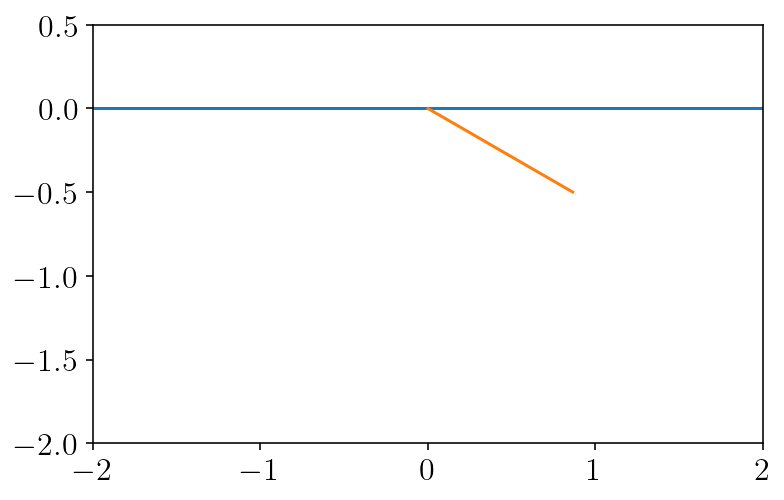

In [5]:
plt.plot(free.pts[:,0], free.pts[:,1])
plt.plot(fault.pts[:,0], fault.pts[:,1])
plt.axis('scaled')
plt.xlim([-2, 2])
plt.ylim([-2, 0.5])
plt.show()


## Compute BIE operators

In [6]:
from tectosaur2.elastic2d import elastic_t, elastic_h

singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [0, 0],
        [float(sp_x.subs(sp_t,1)), float(sp_y.subs(sp_t,1))],
    ]
)
(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    elastic_t(0.25),
    free.pts,
    free,
    fault,
    tol=1e-10,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)

(free_disp_to_obs_disp, fault_slip_to_obs_disp), report = integrate_term(
    elastic_t(0.25),
    obs_pts,
    free,
    fault,
    tol=1e-10,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)

(free_disp_to_obs_stress, fault_slip_to_obs_stress), report = integrate_term(
    elastic_h(0.25),
    obs_pts,
    free,
    fault,
    tol=1e-10,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(


## Run TDE calculations

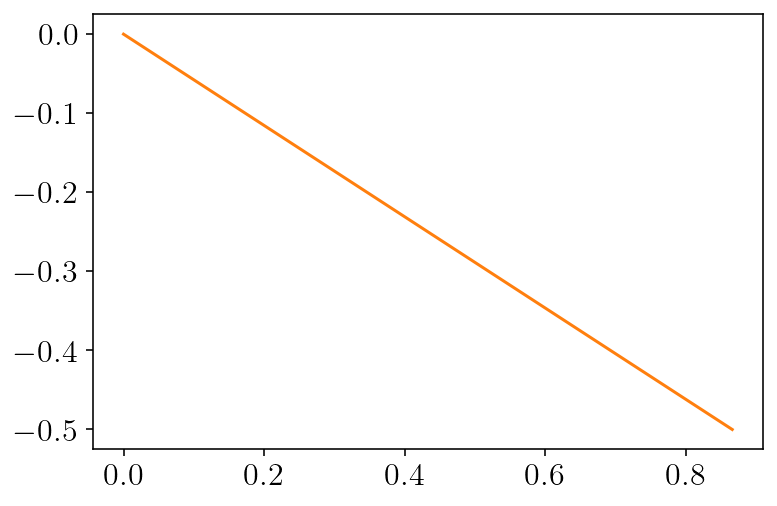

In [7]:
ZL = 500
obs_pts3d = np.zeros((obs_pts.shape[0], 3))
obs_pts3d[:,[0,2]] = obs_pts

x_bottom = float(sp_x.subs(sp_t, 1))
y_bottom = float(sp_y.subs(sp_t, 1))
tris = np.array([
    [[0,-ZL,0],[0,ZL,0],[x_bottom,ZL,y_bottom]],
    [[0,-ZL,0],[x_bottom,ZL,y_bottom],[x_bottom,-ZL,y_bottom]],
])
plt.plot(tris[:,:,0], tris[:,:,2])
plt.show()

In [8]:
slip_tde = np.array([[0.0,-1.0,0.0]] * 2)
slip_tde.shape
fs_strain_mat = FS.strain_matrix(obs_pts3d, tris, 0.25)
fs_strain_cutde = tensor_dot(fs_strain_mat, slip_tde)
fs_stress_cutde3d = FS.strain_to_stress(fs_strain_cutde, 1.0, 0.25)
fs_stress_cutde = fs_stress_cutde3d[:,[0,2,4]]

fs_disp_mat = FS.disp_matrix(obs_pts3d, tris, 0.25)
fs_disp_cutde3d = tensor_dot(fs_disp_mat, slip_tde)
fs_disp_cutde = tensor_dot(fs_disp_mat, slip_tde)[:,[0,2]]

hs_strain_mat = HS.strain_matrix(obs_pts3d, tris, 0.25)
hs_strain_cutde = tensor_dot(hs_strain_mat, slip_tde)
hs_stress_cutde3d = HS.strain_to_stress(hs_strain_cutde, 1.0, 0.25)
hs_stress_cutde = hs_stress_cutde3d[:,[0,2,4]]

hs_disp_mat = HS.disp_matrix(obs_pts3d, tris, 0.25)
hs_disp_cutde3d = tensor_dot(hs_disp_mat, slip_tde)
hs_disp_cutde = tensor_dot(hs_disp_mat, slip_tde)[:,[0,2]]

## Check fullspace fields

In [9]:
nx = fault.normals[:, 0]
ny = fault.normals[:, 1]
slip = np.stack((-ny, nx), axis=1)
fs_stress_tct2 = -tensor_dot(fault_slip_to_obs_stress, slip)
fs_disp_tct2 = -tensor_dot(fault_slip_to_obs_disp, slip)

In [10]:
fault_slip_to_free_disp = fault_slip_to_free_disp.reshape((-1, 2 * fault.n_pts))
free_disp_to_free_disp = free_disp_to_free_disp.reshape((-1, 2 * free.n_pts))

free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
)
rhs = -fault_slip_to_free_disp.dot(slip.ravel())
free_disp = np.linalg.solve(free_disp_solve_mat, rhs).reshape((-1, 2))
hs_disp_tct2 = -tensor_dot(free_disp_to_obs_disp, free_disp) - tensor_dot(fault_slip_to_obs_disp, slip)
hs_stress_tct2 = -tensor_dot(free_disp_to_obs_stress, free_disp) - tensor_dot(fault_slip_to_obs_stress, slip)

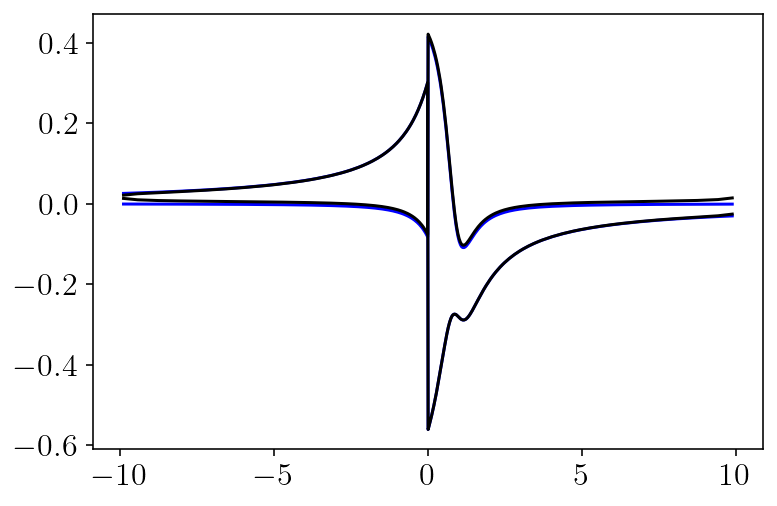

In [15]:

free_pts3d = np.zeros((free.n_pts, 3))
free_pts3d[:, [0,2]] = free.pts
free_pts3d[:, 2] += 1e-10
free_disp_mat = HS.disp_matrix(free_pts3d, tris, 0.25)
free_disp_cutde = tensor_dot(free_disp_mat, slip_tde)[:,[0,2]]
plt.plot(free.pts[:, 0], free_disp_cutde, 'b-')
plt.plot(free.pts[:, 0], free_disp, 'k-')
plt.show()






fullspace stress
fullspace stress
fullspace stress


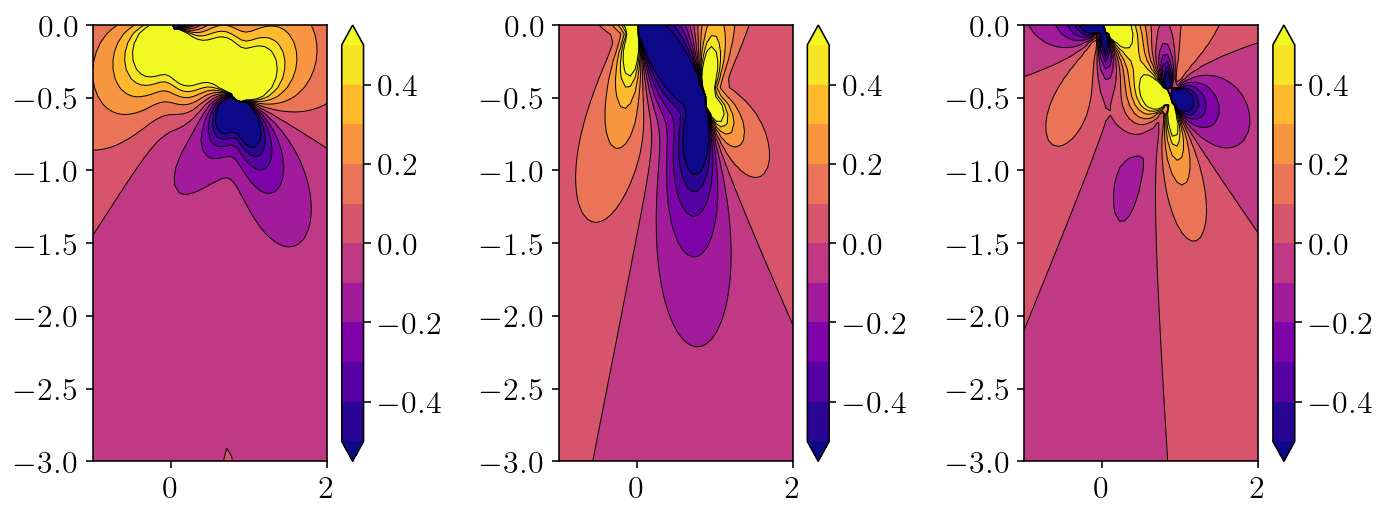

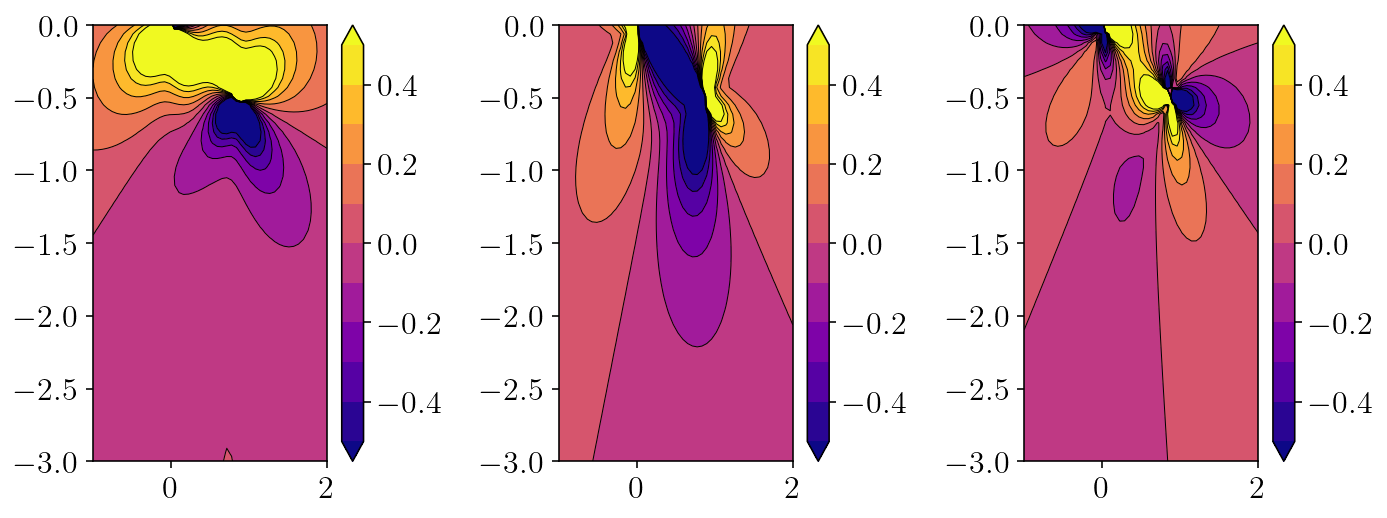

-6.92254512872888 -5.735593402070701
-7.901133274614626 -6.1969012068550935
-8.44773160110128 -6.216095834112237


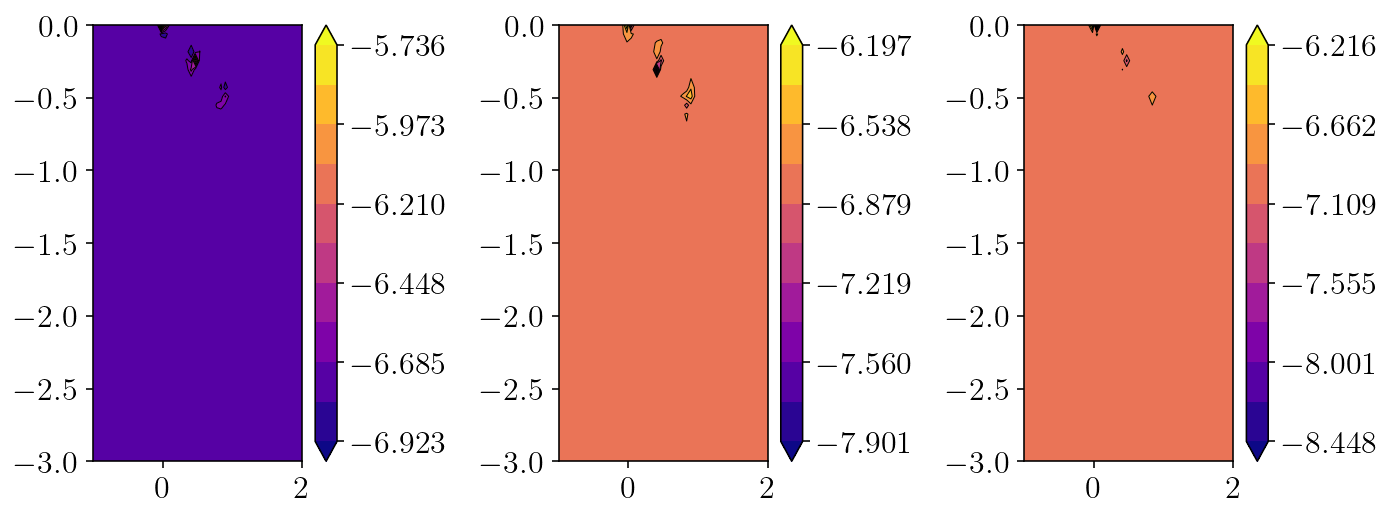






fullspace displacement
fullspace displacement
fullspace displacement


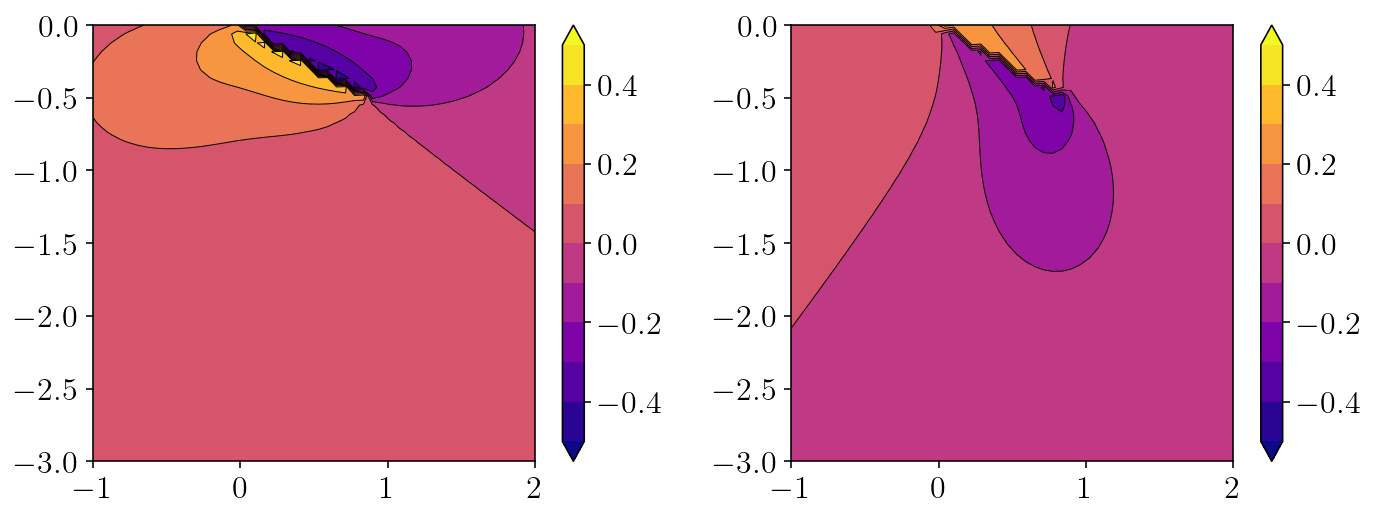

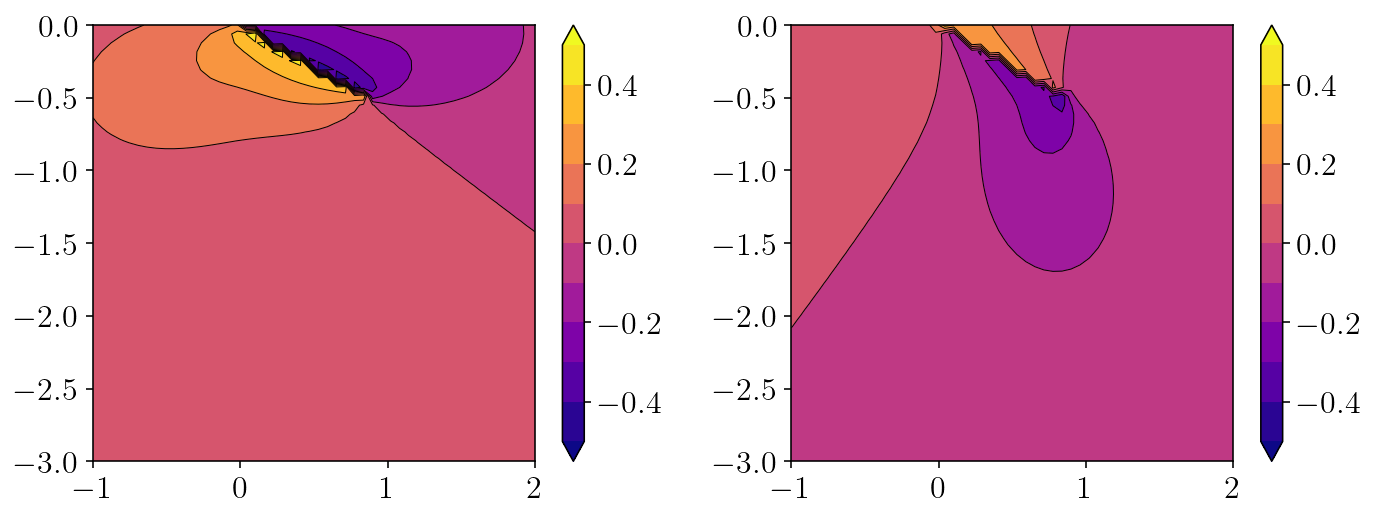

-10.185839086958637 -6.556641324507732
-10.354174931228416 -6.473882772620908


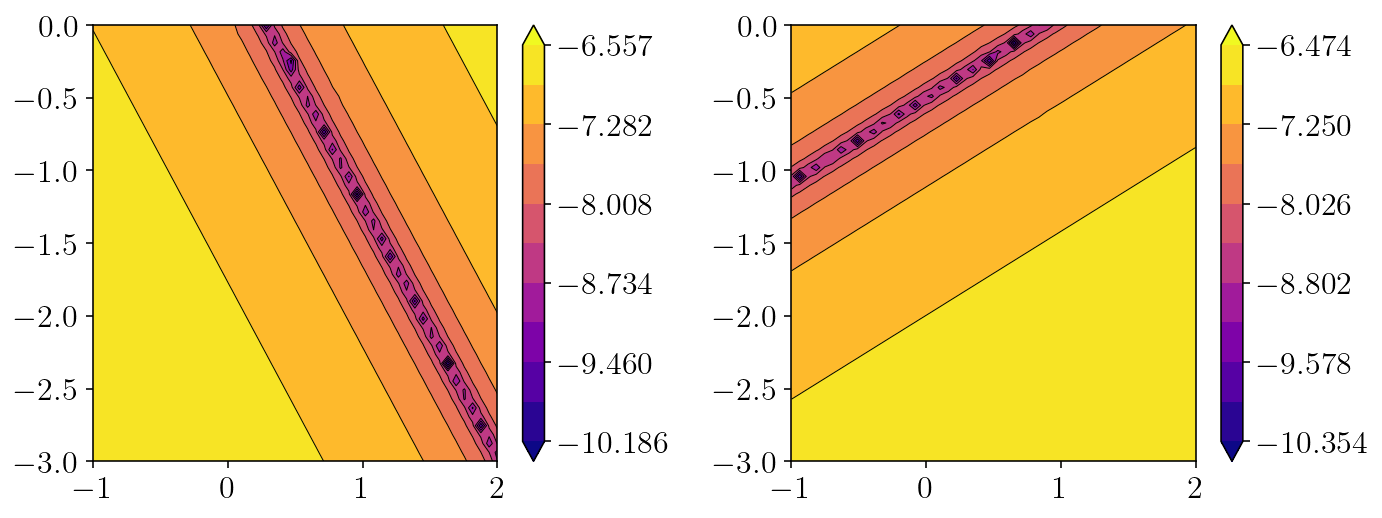






halfspace stress
halfspace stress
halfspace stress


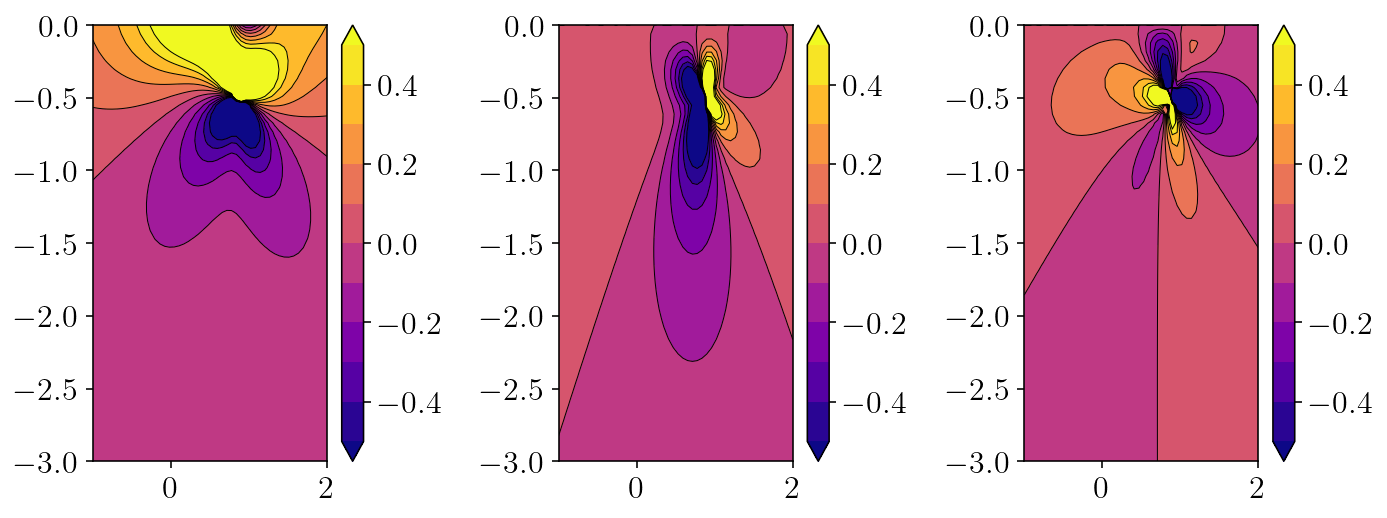

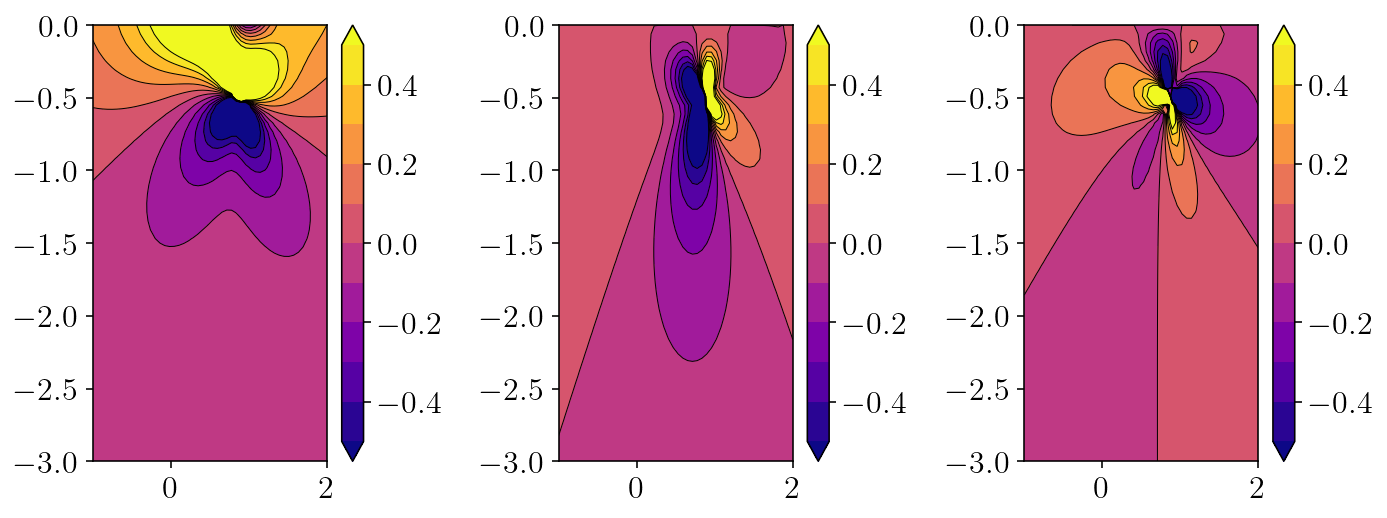

-4.133200775212703 -2.981443200393265
-8.150715369874593 -3.160934890740736
-7.62879751255069 -3.282912368646698


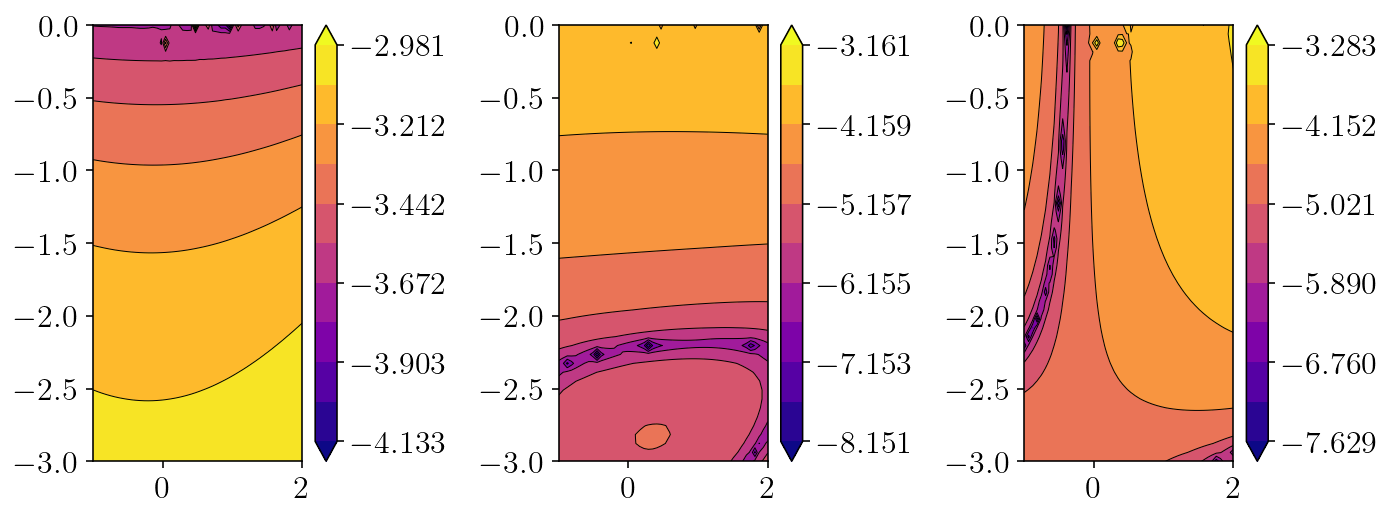






halfspace displacement
halfspace displacement
halfspace displacement


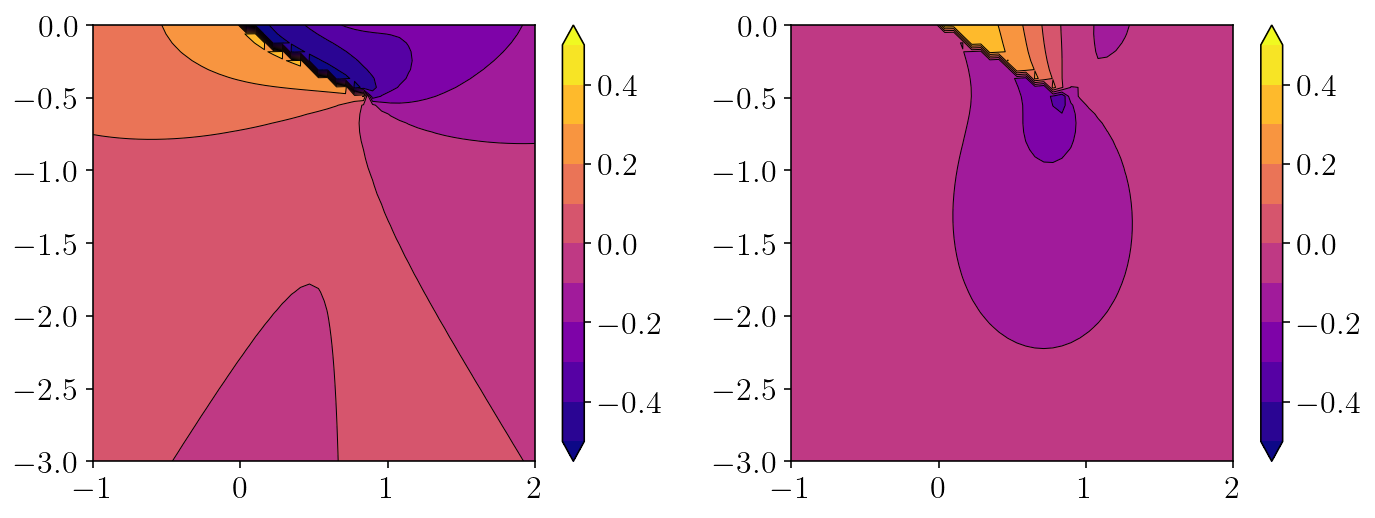

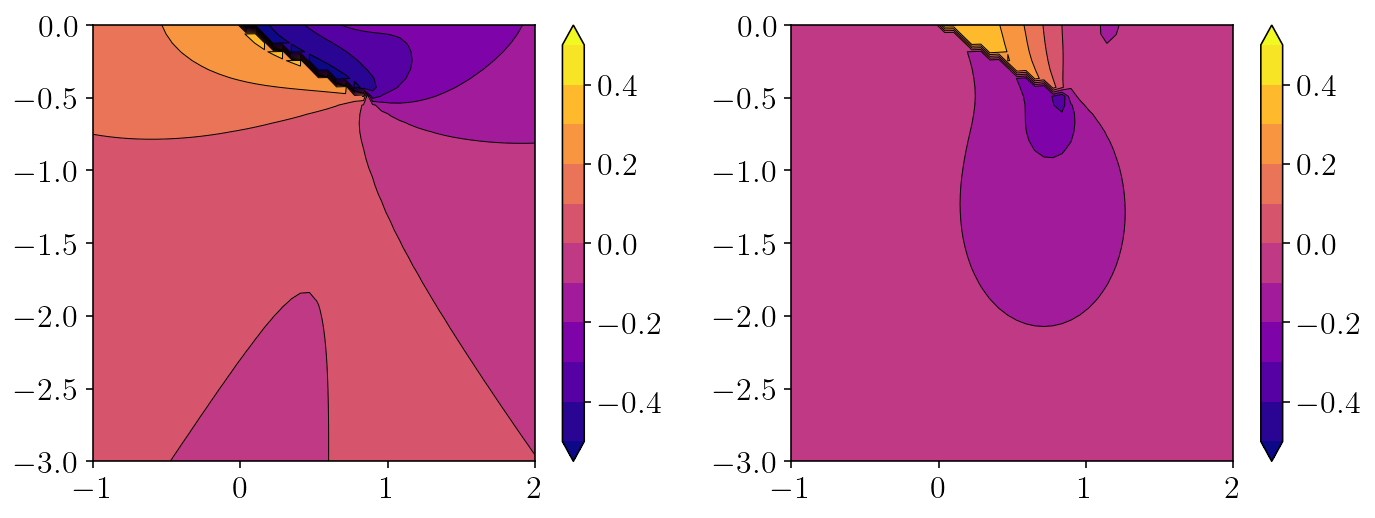

-8.094012895474224 -3.1323122612333343
-2.264355308249028 -2.204336718319069


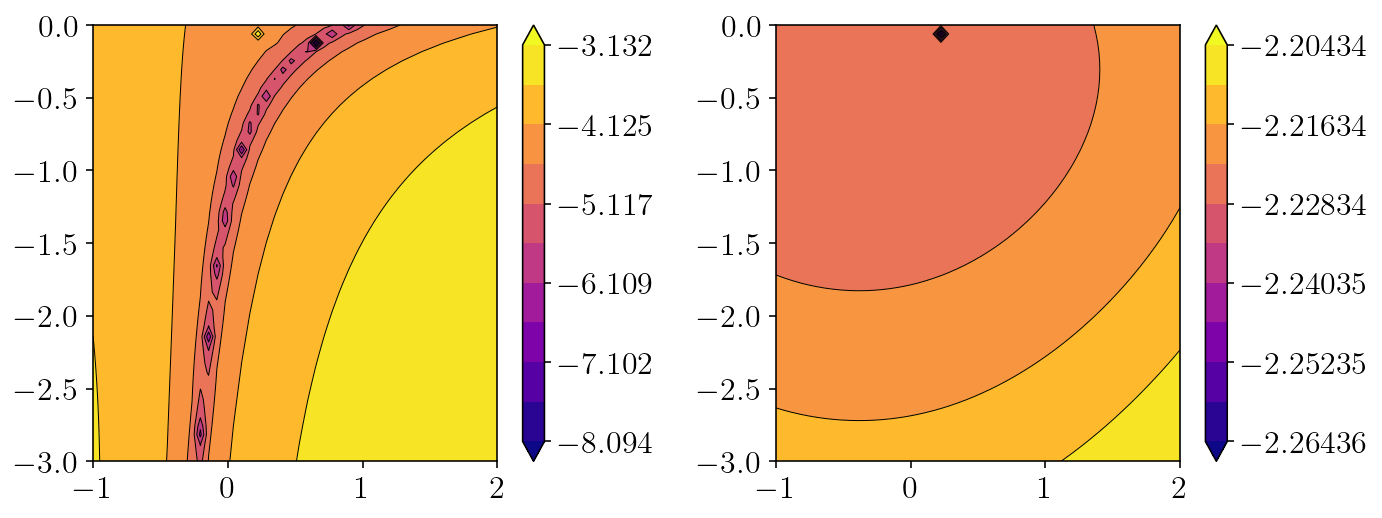

In [101]:
xs = obs_pts[:, 0].reshape((nobs, nobs))
ys = obs_pts[:, 1].reshape((nobs, nobs))

for name, va, vb in [
    ("fullspace stress", fs_stress_cutde, fs_stress_tct2),
    ("fullspace displacement", fs_disp_cutde, fs_disp_tct2),
    ("halfspace stress", hs_stress_cutde, hs_stress_tct2),
    ("halfspace displacement", hs_disp_cutde, hs_disp_tct2),
]:
    nd = va.shape[1]
    print('\n\n\n\n')
    print(name)
    print(name)
    print(name)
    for v in [va, vb]:
        plt.figure(figsize=(10, 4))
        for i in range(nd):
            plt.subplot(1, nd, 1 + i)
            v2d = v[:, i].reshape((nobs, nobs))
            levels = np.linspace(-0.5, 0.5, 11)
            cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
            plt.contour(
                xs,
                ys,
                v2d,
                colors="k",
                linestyles="-",
                linewidths=0.5,
                levels=levels,
                extend="both",
            )
            plt.colorbar(cntf)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(10, 4))
    for i in range(nd):
        plt.subplot(1, nd, 1 + i)
        v2d = np.log10(np.abs(va - vb))[:, i].reshape((nobs, nobs))
        print(np.min(v2d), np.max(v2d))
        levels = np.linspace(np.min(v2d), np.max(v2d), 11)
        cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
        plt.contour(
            xs,
            ys,
            v2d,
            colors="k",
            linestyles="-",
            linewidths=0.5,
            levels=levels,
            extend="both",
        )
        plt.colorbar(cntf)
    plt.tight_layout()
    plt.show()
